# MCP-HaloTag testing

## Data import

In [81]:

from transcription_pipeline import preprocessing_pipeline
RBSPWM_dataset1 = "test_data/2024-02-26/Halo-RBSPWM_embryo01"
InputOutput_embryo1 = "test_data/InputOutput_MCPHaloTag/2024-03-07/embryo1"
InputOutput_embryo2 = "test_data/InputOutput_MCPHaloTag/2024-03-07/embryo2"

test_dataset_name = InputOutput_embryo2

In [70]:
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    import_previous=True, 
)
dataset.save()

In [3]:
# view the dataset as an image file


## Starting a Dask Client for parallelization

In [71]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="6GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

2024-03-26 11:24:41,999 - distributed.deploy.spec - WARNING - Cluster closed without starting up


Cluster already running
<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=78.23 GiB>


## Nuclear Tracking

In [82]:
# Run nuclear segmentation and tracking
from transcription_pipeline import nuclear_pipeline

In [85]:

nuclear_tracking = nuclear_pipeline.Nuclear(
    data=dataset.channels_full_dataset[0],
    global_metadata=dataset.export_global_metadata[0],
    frame_metadata=dataset.export_frame_metadata[0],
    client=client,
    keep_futures=False
    # division_trigger="nuclear_fluorescence",
)

nuclear_tracking.track_nuclei()

# Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
# tracking information.
nuclear_tracking.save_results(name_folder=test_dataset_name)

Frame 486: 72 trajectories present.
Stitching tracks.


TypeError: '<' not supported between instances of 'float' and 'tuple'

In [80]:
nuclear_tracking = nuclear_pipeline.Nuclear()

nuclear_tracking.read_results(name_folder=test_dataset_name)

## Spot analysis

In [47]:
from transcription_pipeline import spot_pipeline

In [48]:
# dataset.original_global_metadata

In [50]:
%%time

spot_tracking = spot_pipeline.Spot(
    data=dataset.channels_full_dataset[0],
    global_metadata=dataset.export_global_metadata[0],
    frame_metadata=dataset.export_frame_metadata[0],
    labels=nuclear_tracking.reordered_nuclear_labels,
    expand_distance=3,
    search_range_um=1.,
    retrack_search_range_um=1.5,
    memory=3,
    min_track_length=2,
    series_splits=dataset.series_splits,
    series_shifts=dataset.series_shifts,
    keep_bandpass=False,
    keep_futures=False,
    keep_spot_labels=False,
    evaluate=True,
    client=client,
)

spot_tracking.extract_spot_traces()
# Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
# quantification information.
spot_tracking.save_results(name_folder=test_dataset_name)

Frame 433: 73 trajectories present.
Stitching tracks.
CPU times: user 7min 6s, sys: 1min 18s, total: 8min 24s
Wall time: 1h 20min 1s


In [26]:
# The following dataset is marked as far posterior in the lab notebook

In [61]:
track_spots = spot_pipeline.Spot()

track_spots.read_results(name_folder=test_dataset_name)

In [62]:
spot_df = track_spots.spot_dataframe

In [63]:
detected_spots = spot_df[spot_df["particle"] != 0]

In [64]:
detected_spots['raw_spot'].head()

1401    [[[1, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 2, 1, 1,...
4034    [[[0, 0, 2, 1, 1, 1, 1, 1, 0], [2, 0, 1, 1, 2,...
4851    [[[0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0,...
6268    [[[0, 0, 1, 0, 0, 0, 0, 3, 0], [0, 0, 0, 1, 0,...
6910    [[[0, 1, 1, 1, 0, 0, 0, 1, 0], [0, 1, 1, 1, 0,...
Name: raw_spot, dtype: object

In [65]:
# replace array in "background_intensity_from_neighborhood" column with the mean of the array
detected_spots['background_intensity_from_neighborhood'] = detected_spots['background_intensity_from_neighborhood'].apply(lambda x: x.mean())

## Show detected spots
detected_spots.head()

/tmp/ipykernel_1808504/135949912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detected_spots['background_intensity_from_neighborhood'] = detected_spots['background_intensity_from_neighborhood'].apply(lambda x: x.mean())


,label,z,y,x,frame,t_s,t_frame,raw_spot,coordinates_start,covariance_matrix,...,amplitude,offset,cost,norm_cost,intensity_from_fit,intensity_std_error_from_fit,intensity_from_neighborhood,intensity_std_error_from_neighborhood,background_intensity_from_neighborhood,particle
1401,3575,4.623866,169.976112,288.006328,1,1.362999,0.0,"[[[1, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 2, 1, 1,...","[0, 2, 165, 283]","[[0.05425730305859694, 0.009561000461091136, -...",...,17.544097,0.348337,68.803102,0.001651,15.101968,6955.946303,20.456429,17.910865,84.496571,705
4034,3386,4.910579,122.163118,283.911564,2,5.150000,1.0,"[[[0, 0, 2, 1, 1, 1, 1, 1, 0], [2, 0, 1, 1, 2,...","[1, 2, 118, 279]","[[0.07600719257001222, -4.2777536349366335e-05...",...,1.572482,0.377393,74.223909,0.019131,9.167540,4.455577,13.482727,17.590112,94.253273,719
4851,5538,9.005782,207.522563,322.105847,2,6.522999,1.0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0,...","[1, 6, 203, 317]","[[0.11480522555189066, 7.99241235062002e-07, -...",...,1.432367,0.471812,112.546851,0.025863,12.984993,6.622086,21.195000,21.506753,124.218000,692
6268,2369,2.891200,167.842400,284.295586,3,8.257999,2.0,"[[[0, 0, 1, 0, 0, 0, 0, 3, 0], [0, 0, 0, 1, 0,...","[2, 0, 163, 279]","[[0.04604330000578199, 1.0455188316350328e-05,...",...,1.493317,0.365816,73.519695,0.020050,12.879236,5.464992,12.723867,17.926471,94.224133,705
6910,3987,7.131231,229.532159,230.081773,3,9.618000,2.0,"[[[0, 1, 1, 1, 0, 0, 0, 1, 0], [0, 1, 1, 1, 0,...","[2, 4, 225, 225]","[[0.052498291260658796, -4.520626986448387e-08...",...,1.298770,0.404925,90.826677,0.025623,22.121545,8.929206,24.115899,20.255534,103.453101,710


# Extract Spot Shell and Look at Correlations

In [ ]:
spot_pipeline.extract_spot_shell(detected_spots, spot_df, track_spots)

In [66]:
import matplotlib.pyplot as plt

In [67]:
plt.close()

(3535,) (3535,)


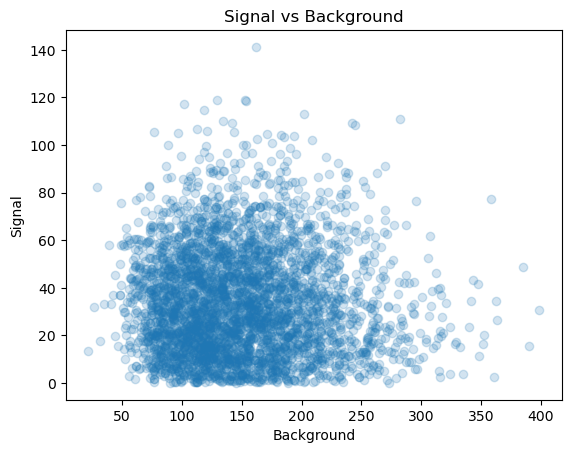

[[ 1.         -0.01855333]
 [-0.01855333  1.        ]]


In [68]:
import numpy as np
signal = np.array(detected_spots['intensity_from_neighborhood'])
background = np.array(detected_spots['background_intensity_from_neighborhood'])
print(signal.shape, background.shape)
plt.scatter(x=background, y=signal, alpha=0.2)
plt.xlabel('Background')
plt.ylabel('Signal')
plt.title('Signal vs Background')
plt.show()

# Compute the correlation between signal and background
#np.corrcoef(signal, background)
print(np.corrcoef(signal, background))

[3.92659588 5.15656098 6.85839011 ... 2.44353843 2.84413819 2.5383256 ]


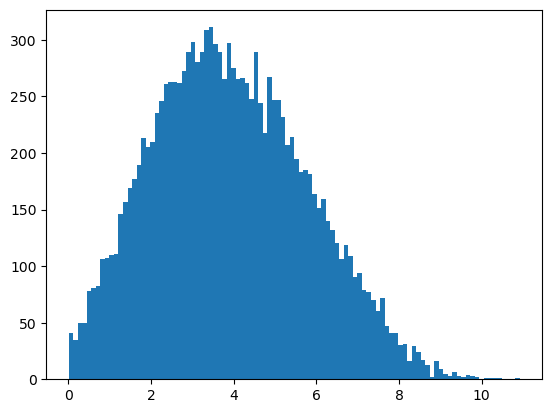

In [17]:
import numpy as np
snr = (
    detected_spots["intensity_from_neighborhood"]
    / detected_spots["intensity_std_error_from_neighborhood"]
)
print(np.array(snr))
## Make snr histogram
plt.figure()
plt.hist(snr, bins=100)
plt.show()

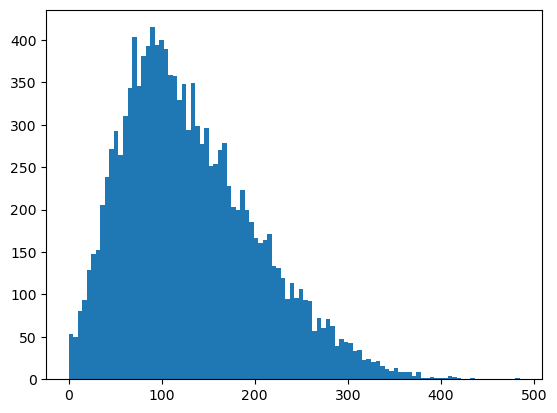

In [14]:
signal = (detected_spots["intensity_from_neighborhood"])

## Make signal histogram
plt.figure()
plt.hist(signal, bins=100)
plt.show()
# plt.close()

In [15]:
from transcription_pipeline.spot_analysis import compile_data

In [16]:
compiled_dataframe = compile_data.compile_traces(
    detected_spots,
    compile_columns_spot=[
        "frame",
        "t_s",
        "intensity_from_neighborhood",
        "intensity_std_error_from_neighborhood",
        "x",
        "y"
    ],
    nuclear_tracking_dataframe=None,
)

In [17]:
compiled_dataframe

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y
0,1,"[286, 287, 288, 289, 290, 294, 295, 296, 298, ...","[2054.9270000457764, 2059.8470001220703, 2064....","[91.28756387665199, 132.9718193832599, 105.253...","[29.473318897189117, 28.798626986155796, 27.67...","[900.5547083872307, 901.0618546876169, 901.126...","[153.30323726422256, 153.5371279570444, 154.12..."
1,2,"[324, 325, 326, 327, 328, 330, 331, 332, 333, ...","[2241.6420001983643, 2246.82200050354, 2251.74...","[38.701353488372085, 121.29204545454547, 165.3...","[32.31518204860334, 29.89363065382583, 26.8540...","[749.287404711558, 748.8603665247351, 748.9894...","[8.979979857042522, 9.077905816909453, 8.56891..."
2,3,"[320, 321, 323, 324, 325, 328, 329, 330, 331, ...","[2222.8819999694824, 2227.8020000457764, 2237....","[15.132814285714286, 50.240405405405404, 72.03...","[29.649465125061617, 27.280158065651396, 29.72...","[752.0407040347145, 752.1436105513166, 751.444...","[74.05522703333558, 71.18655994852311, 71.3463..."
3,4,"[331, 332, 333, 334, 336, 337, 338, 339, 340, ...","[2276.582000732422, 2281.2670001983643, 2286.8...","[55.62481182795699, 51.74029186602871, 65.9324...","[28.10089735906176, 26.01496392382907, 25.2238...","[867.4307168792935, 867.4907822731141, 866.175...","[219.58398925617502, 221.19493431207792, 220.5..."
4,5,"[331, 332, 333, 334, 335, 336, 337, 339, 340, ...","[2277.0470008850098, 2281.7299995422363, 2286....","[65.77666666666666, 88.77969736842104, 75.2179...","[24.845596748272676, 23.733336043987475, 25.69...","[886.1030893314778, 886.2475508614874, 887.106...","[50.268361696799516, 52.57886140096148, 52.572..."
...,...,...,...,...,...,...,...
473,1423,"[4, 5, 6, 9, 12, 13]","[18.48000144958496, 20.84000015258789, 25.7630...","[82.18738207547169, 21.4192427184466, 5.512583...","[33.08661639922334, 59.772424976130864, 48.104...","[314.7854845504599, 319.9785327423137, 324.504...","[170.5622522336089, 179.44144265027035, 189.47..."
474,1424,"[6, 7, 8, 9, 13]","[25.9950008392334, 30.915000915527344, 35.8400...","[97.856, 86.39966666666666, 41.747903083700436...","[53.56986899367965, 51.52575127383718, 50.2334...","[150.89376194384255, 144.27985843593822, 140.0...","[30.046021034490806, 29.10762465664844, 33.730..."
475,1428,"[1, 3, 4, 5, 8, 13]","[3.2550010681152344, 13.095001220703125, 18.71...","[221.15557711442787, 123.7193025210084, 211.89...","[38.63029483330309, 32.884616059013126, 36.434...","[422.3097049670606, 423.75520932692683, 423.38...","[44.31437185581244, 45.71750093235114, 47.8825..."
476,1463,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[2.5600013732910156, 7.475000381469727, 12.400...","[259.8098806584362, 333.22636842105265, 208.61...","[37.88205050059377, 42.82487798272702, 39.3812...","[910.8499021374608, 912.6836174113239, 915.194...","[100.4965436710039, 102.71249488066775, 101.32..."


## Visualizing traces

In [22]:
from transcription_pipeline.utils import plottable

In [23]:
# Restrict to longer traces
min_frames = 40
traces_compiled_dataframe = compiled_dataframe[
    compiled_dataframe["frame"].apply(lambda x: x.size) > min_frames
]

In [24]:
plt.close()

/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/utils/plottable.py:17: UserWarning: Could not determine division time, using absolute time.
  warnings.warn("Could not determine division time, using absolute time.")


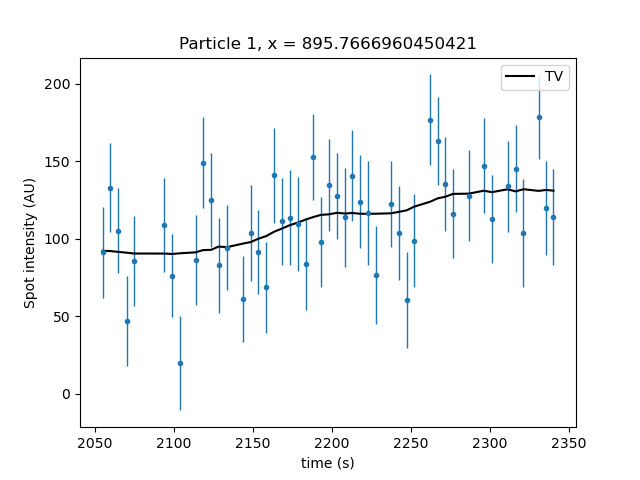

In [25]:
%matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle


traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)
# median_filtered_traces = [medfilt(trace[1], kernel_size=9) for trace in traces]

tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=180, max_num_iter=500) for trace in traces
]
# potts_steps_traces = [
#     potts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.errorbar(
        traces[curr_pos][0],
        traces[curr_pos][1],
        yerr=traces[curr_pos][2],
        fmt=".",
        elinewidth=1,
    )
    # ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
    ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
    # ax.step(
    #     traces[curr_pos][0],
    #     potts_steps_traces[curr_pos],
    #     where="mid",
    #     color="red",
    #     label="Potts L1",
    # )
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")

    particle = traces[curr_pos][3]
    mean_x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
        .mean()
    )
    ax.set_title(f"Particle {particle}, x = {mean_x}")
    ax.legend()
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    traces[curr_pos][0],
    traces[curr_pos][1],
    yerr=traces[curr_pos][2],
    fmt=".",
    elinewidth=1,
)
# ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
# ax.step(
#     traces[curr_pos][0],
#     potts_steps_traces[curr_pos],
#     where="mid",
#     color="red",
#     label="Potts L1",
# )
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[curr_pos][3]
mean_x = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
    .values[0]
    .mean()
)
ax.set_title(f"Particle {particle}, x = {mean_x}")
ax.legend()

plt.show()

/tmp/ipykernel_4024375/3582373522.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=colors, cmap='plasma', s=10)


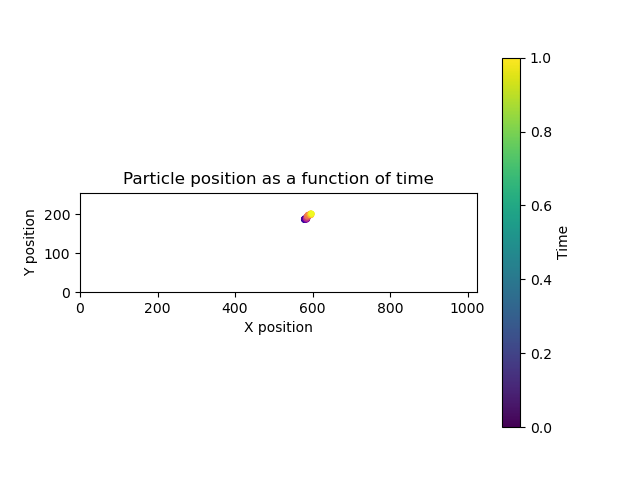

In [23]:
particle = traces[curr_pos][3]
x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
    )
y = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "y"]
        .values[0]
    )
t = traces[curr_pos][0]
# Create a colormap ranging from 0 to 1
cmap = plt.get_cmap('plasma')

# Normalize time values to [0,1] for color mapping
norm = plt.Normalize(t.min(), t.max())
colors = cmap(norm(t))

# Plot x and y positions with color changing with time
plt.figure()
plt.scatter(x, y, c=colors, cmap='plasma', s=10)
plt.colorbar(label='Time')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.xlim([0, 1024])
plt.ylim([0, 256])
plt.title('Particle position as a function of time')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# plt.figure()
# plt.scatter(t,x, marker='.')
# plt.ylabel('x coordinate')
# plt.xlabel('time (s)')
# plt.show()

In [122]:
import pandas as pd
import numpy as np
print(compiled_dataframe.index)
Bins = pd.cut(compiled_dataframe["x"]
        .values[0]
        .mean(), bins=10)

RangeIndex(start=0, stop=478, step=1)


ValueError: Input array must be 1 dimensional

In [311]:
curr_pos

58

In [301]:
plt.close()

In [ ]:
# Indices: 9, 13, 14?, 36, 58

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


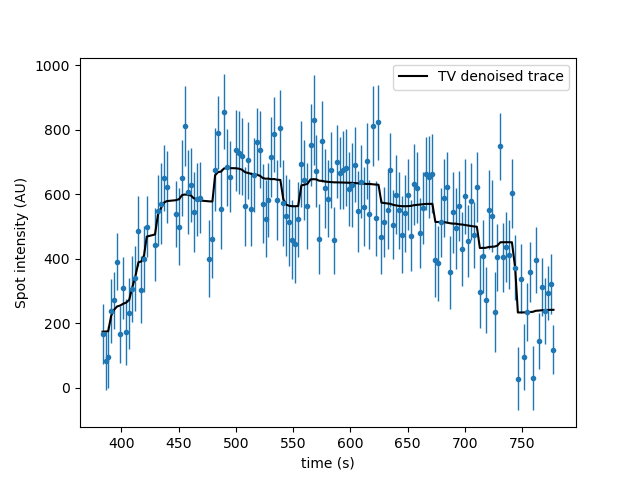

In [325]:
i = 58
fig = plt.figure()
# Step-like particles: 64, 72?, 87, 152fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    traces[i][0],
    traces[i][1],
    yerr=traces[i][2],
    fmt=".",
    elinewidth=1,
)
# ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
ax.plot(traces[i][0], tv_denoised_traces[i], color="k", label="TV denoised trace")
# ax.step(
#     traces[curr_pos][0],
#     potts_steps_traces[curr_pos],
#     where="mid",
#     color="red",
#     label="Potts L1",
# )
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[i][3]
# mean_x = (
#     compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
#     .values[0]
#     .mean()
# )
# ax.set_title(f"Particle {particle}, x = {mean_x}")
ax.legend()
plt.savefig("halotag_sm_trace_4.svg", format="svg")
plt.savefig("halotag_sm_trace_4.eps", format="eps")

plt.show()

## Testing

In [326]:
plt.close()

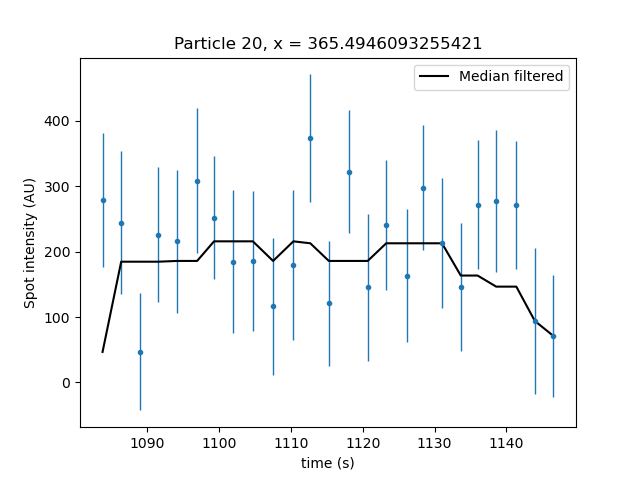

In [327]:
%matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle


traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)
median_filtered_traces = [medfilt(trace[1], kernel_size=15) for trace in traces]

# tv_denoised_traces = [
#     denoise_tv_chambolle(trace[1], weight=180, max_num_iter=500) for trace in traces
# ]
# potts_steps_traces = [
#     potts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.errorbar(
        traces[curr_pos][0],
        traces[curr_pos][1],
        yerr=traces[curr_pos][2],
        fmt=".",
        elinewidth=1,
    )
    ax.plot(
        traces[curr_pos][0],
        median_filtered_traces[curr_pos],
        color="k",
        label="Median filtered",
    )
    # ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
    # ax.step(
    #     traces[curr_pos][0],
    #     potts_steps_traces[curr_pos],
    #     where="mid",
    #     color="red",
    #     label="Potts L1",
    # )
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")

    particle = traces[curr_pos][3]
    mean_x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
        .mean()
    )
    ax.set_title(f"Particle {particle}, x = {mean_x}")
    ax.legend()
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    traces[curr_pos][0],
    traces[curr_pos][1],
    yerr=traces[curr_pos][2],
    fmt=".",
    elinewidth=1,
)
ax.plot(
    traces[curr_pos][0],
    median_filtered_traces[curr_pos],
    color="k",
    label="Median filtered",
)
# ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
# ax.step(
#     traces[curr_pos][0],
#     potts_steps_traces[curr_pos],
#     where="mid",
#     color="red",
#     label="Potts L1",
# )
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[curr_pos][3]
mean_x = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
    .values[0]
    .mean()
)
ax.set_title(f"Particle {particle}, x = {mean_x}")
ax.legend()

plt.show()

In [43]:
curr_pos

13

In [49]:
i = 13
time, trace, filt_trace = traces[i][0], traces[i][1], median_filtered_traces[i]

In [50]:
down_time_mask = time > 580
down_time, down_trace, down_filt_trace = (
    time[down_time_mask],
    trace[down_time_mask],
    filt_trace[down_time_mask],
)

In [51]:
plt.close()

(array([ 6.,  8., 14., 18., 12.,  7., 15., 23., 33., 25.,  9.,  3.]),
 array([ 104.9413741 ,  184.45609824,  263.97082239,  343.48554653,
         423.00027068,  502.51499482,  582.02971897,  661.54444311,
         741.05916725,  820.5738914 ,  900.08861554,  979.60333969,
        1059.11806383]),
 <BarContainer object of 12 artists>)

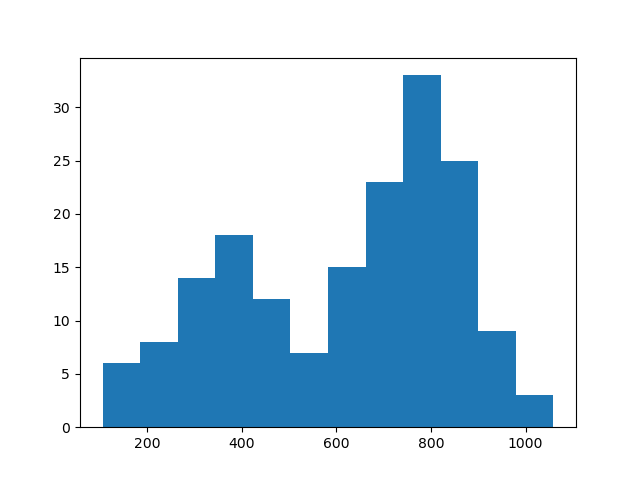

In [66]:
plt.close()
plt.hist(down_trace, bins=12)

In [78]:
import numpy as np

In [79]:
pooled_intensities = np.array([])
for trace_tuple in traces:
    pooled_intensities = np.append(pooled_intensities, trace_tuple[1])

In [94]:
pooled_errors = np.array([])
for trace_tuple in traces:
    pooled_errors = np.append(pooled_errors, trace_tuple[2])

pooled_inv_var = 1 / (pooled_errors**2)

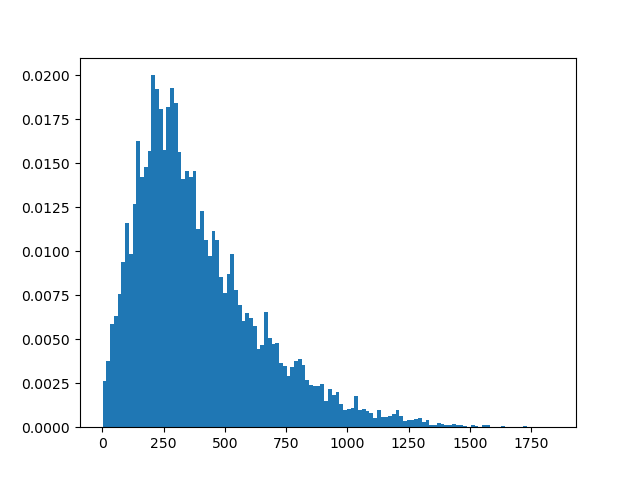

In [267]:
plt.close()
plt.hist(pooled_intensities, weights=pooled_inv_var, bins=120, log=False)
plt.show()

In [147]:
from scipy import stats, signal

In [268]:
kde_estimate = stats.gaussian_kde(
    pooled_intensities, weights=pooled_inv_var, bw_method=0.04
)
intensity_val_hist = np.linspace(
    pooled_intensities.min(), pooled_intensities.max(), num=500
)
kde_values = kde_estimate(intensity_val_hist)

peaks = signal.find_peaks(kde_values, height=0.0003)
peak_x_values = intensity_val_hist[peaks[0]]
peak_y_values = kde_values[peaks[0]]

In [269]:
spacing = peak_x_values[1:] - peak_x_values[:-1]

In [270]:
spacing

array([ 66.37377204,  70.06120382,  66.37377204, 110.62295341,
        62.68634026,  77.43606738,  66.37377204, 136.43497587])

In [271]:
approx_num_steps = np.round(peak_x_values / 66.37)

In [272]:
regression = stats.linregress(approx_num_steps, peak_x_values)
mean_spacing = regression.slope
intercept = regression.intercept

In [289]:
regression

LinregressResult(slope=64.70373953492735, intercept=19.989669930440584, rvalue=0.9994000836301473, pvalue=1.7402081968656995e-11, stderr=0.8474931354163013, intercept_stderr=6.26610237151058)

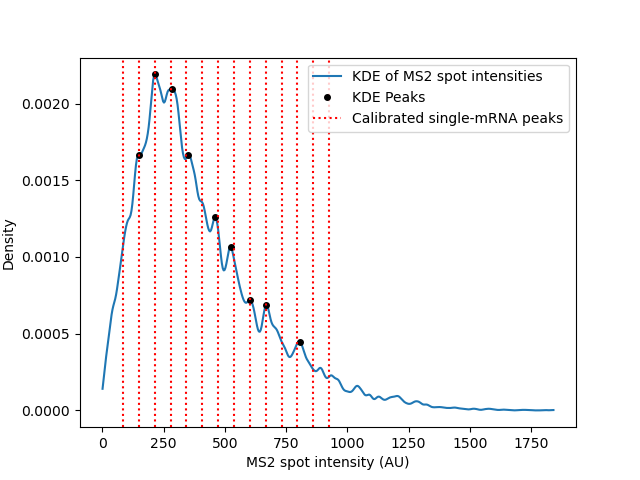

In [291]:
plt.close()
plt.plot(intensity_val_hist, kde_values, label="KDE of MS2 spot intensities")
plt.plot(
    peak_x_values,
    peak_y_values,
    linestyle="",
    marker="o",
    markersize=4,
    color="k",
    label="KDE Peaks",
)
plt.axvline(
    x=mean_spacing + intercept,
    color="r",
    ls=":",
    label="Calibrated single-mRNA peaks",
)
for i in range(2, 15):
    plt.axvline(
        x=i * mean_spacing + intercept,
        color="r",
        ls=":",
    )

plt.xlabel("MS2 spot intensity (AU)")
plt.ylabel("Density")

plt.legend()

# plt.savefig("HaloTag_single_mRNA_calibration.eps", format='eps')
# plt.savefig("HaloTag_single_mRNA_calibration.svg", format='svg')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


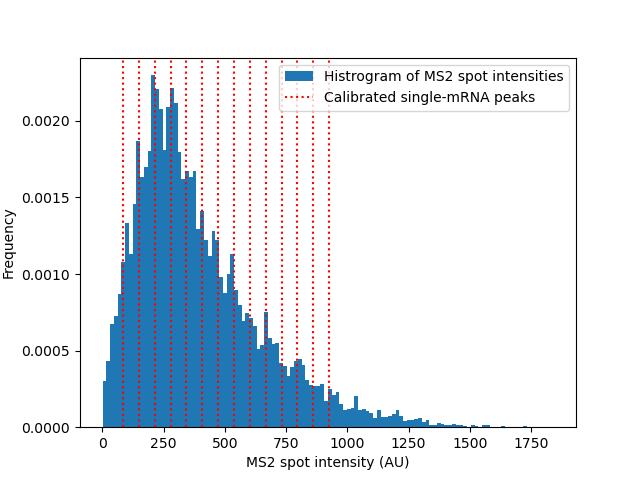

In [295]:
plt.close()
plt.hist(
    pooled_intensities,
    weights=pooled_inv_var,
    bins=120,
    log=False,
    label="Histrogram of MS2 spot intensities",
    density=True,
)
# plt.plot(
#     peak_x_values,
#     peak_y_values,
#     linestyle="",
#     marker="o",
#     markersize=4,
#     color="k",
#     label="KDE Peaks",
# )
plt.axvline(
    x=mean_spacing + intercept,
    color="r",
    ls=":",
    label="Calibrated single-mRNA peaks",
)
for i in range(2, 15):
    plt.axvline(
        x=i * mean_spacing + intercept,
        color="r",
        ls=":",
    )

plt.xlabel("MS2 spot intensity (AU)")
plt.ylabel("Frequency")

plt.legend()

plt.savefig("HaloTag_single_mRNA_calibration_histogram.eps", format="eps")
plt.savefig("HaloTag_single_mRNA_calibration_histogram.svg", format="svg")
plt.show()